# Learn simple layer of LSTM


See the installation file to be able to run this file. 
If you find this file usefull, please cite the corresponding ICASSP2018 doi reference in your work.

In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
"""lstm for guitar signal with input feature for gain parameters, jupyter notebook version"""
import os
import sys
sys.path.append('Codes')
import tensorflow as tf
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pickle
from dataShaping import *
from savePerf import *
import scipy.io.wavfile
import time
from tensorflow.python.tools import freeze_graph


modelName = "LSTM9_ICASSP"
# create directory experiment
date = time.strftime("%Y-%m-%d-%H-%M")
path = os.path.join("experiments",date)
if not os.path.isdir(path):
    os.makedirs(path)
    #experiment/"date"/temp will contain the backuped model parameters
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
    # if you run the file two time in a minute
else :
    date = date+'(2)'
    path = os.path.join("experiments",date)
    os.makedirs(path)
    pathTemp = os.path.join(path,'temp')
    os.makedirs(pathTemp)
	
# directory that will contain tensorboard information
pathLog = 'tf_logs'
if not os.path.isdir(pathLog):
    os.makedirs(pathLog)
pathLog = "{}/run-{}/".format(pathLog,date)

version = tf.__version__
print ("version {} of tensorflow".format(version))

#############################
# Model parameters
#############################
trainTestRatio = 0.9
#if you cannot load all the data set in Ram specify wich part you want to load (0 means all the dataset)
maxSize = int(np.floor(44100*11.4))
num_step = 100                                          #time step
num_hidden = 100                                      #num of hidden units
num_class = 1                                          #size of the output
num_feature = 1                                        # size of the input
batch_size = 600                                      # number of sequence taken before to compute the gradient
n_layer =1                                             #num_layer
num_epoch = 100000                                       # process all the datas num_epoch times
trainDuration = 60*60*24                               # or during a determined duration(second)
fileName = 'Datasets/training.mat'             #dataset train/test path
fileNameValidation = 'Datasets/validation.mat' # dataset validation path


#############################
# Loading data
#############################
matrix = sio.loadmat(fileName)
matrix = matrix['training']
if maxSize ==0:
    maxSize = len(matrix)
    print(maxSize)
# to do shuffle matrix by num_step length
train_input,train_output,test_input,test_output = splitShuffleData(matrix,num_step,trainTestRatio,maxSize)
print("shape input train {}".format(np.shape(train_input)))
numTrain = len(train_output)
print ("Data loaded")
#######################
#Graph
#######################

G = tf.Graph()
with G.as_default():
    with tf.name_scope("placeHolder"):
        data = tf.placeholder(tf.float32, [None, num_step], name ="data") #Number of examples, number of input step (time step), dimension of each input
        target = tf.placeholder(tf.float32, [None, num_class],name = "target") # batchSize, nbClass

    dataShaped = tf.reshape(data,[tf.shape(data)[0],num_step,num_feature])
    
    def lstm_cell():
        return tf.contrib.rnn.LSTMCell(num_hidden,state_is_tuple=True,activation = tf.nn.tanh)
    
    multiLayerCell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(n_layer)] )

    with tf.name_scope("extractLastValueLSTM"):
        val, state = tf.nn.dynamic_rnn(multiLayerCell, dataShaped, dtype=tf.float32) # val dim is [batchSize,sequencelength, numhidden]
    # Let's first fetch the last index of seq length
    # last_index would have a scalar value
        last_index = tf.shape(val)[1] - 1
    # Then let's reshape the output to [sequence_length,batch_size,numhidden]
    # for convenience
        val = tf.transpose(val,[1,0,2])
    # Last state of all batches
        last = tf.nn.embedding_lookup(val,last_index) # tensor [batchsize,numhidden]

    #Send the output of the lsat LSTM cell into a Fully connected layer to compute the prediciton pred[n]  
    with tf.name_scope("FCLayer"):
        weight = tf.get_variable("weight", shape=[num_hidden, int(target.get_shape()[1])], initializer=tf.contrib.layers.xavier_initializer())
        bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))

    prediction = tf.nn.elu((tf.add(tf.matmul(last, weight) , bias)),name = "prediction") #[batchSize,nclass]

    #Compute the mean square error
    MSE = tf.reduce_mean(tf.square(prediction-target))
    
    # create optimizer
    optimizer = tf.train.AdamOptimizer()
    #Compute gradient and apply backpropagation
    minimize = optimizer.minimize(MSE)

    # Create summary view for tensorboard
    mse_summary = tf.summary.scalar('RMSE',tf.sqrt(MSE))
    summary_op = tf.summary.merge_all()
    
    #Create an init op to initialize variable
    init_op = tf.global_variables_initializer()
    saver = tf.train.Saver() # save variable, use saver.restore(sess,"date/tmp/my_model.ckpt") instead of sess.run(init_op)

##############################
# Execution du graphe
##############################
    
with tf.Session(graph=G) as sess:
    #restorePath = os.path.join('2017-09-11-18-07','temp','my_model.ckpt') # example for restore a previous model
    #saver.restore(sess,restorePath)
    sess.run(init_op)
    train_writer = tf.summary.FileWriter(pathLog+'train',graph =tf.get_default_graph())
    test_writer = tf.summary.FileWriter(pathLog+'test')

    no_of_batches = int(np.floor((numTrain)/batch_size)) # numtrain -numstep ?
    no_of_batchesTest = int(np.floor((len(test_input))/batch_size))
    tStart = time.clock()
    epoch =0
    for epoch in range(num_epoch):
        if (time.clock()-tStart < trainDuration):
            ptr = 0
            if epoch % 10==0 : # each ten epoch save the model
                tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myGraph.pb',as_text=False)
                save_path = saver.save(sess,os.path.join(pathTemp,'my_model.ckpt'))
            for j in range(no_of_batches):
                inp, out = train_input[ptr:ptr+batch_size],train_output[ptr:ptr+batch_size]
                
                ptr+=batch_size
                if j % np.floor(trainTestRatio*10) ==0 : # This is to have a train summary and a test summary of the same size
                    _,summary_str = sess.run([minimize,summary_op],{data: inp, target: out})
                    step = epoch*no_of_batches+j
                    train_writer.add_summary(summary_str,step)
                else :
                    sess.run([minimize],{data: inp, target: out})
                   
                #print value
            print ("Epoch -{} calculated ".format(epoch))
            # evaluate the model on the test set (compute the mean of the MSE)
            pMSE = 0
            ptr2 = 0
            for k in range(no_of_batchesTest):
                pMSETemp,summary_str = sess.run([MSE,summary_op],{data: test_input[ptr2:ptr2+batch_size] , target: test_output[ptr2:ptr2+batch_size]})
                pMSE += pMSETemp
                ptr2+=batch_size
                step = epoch*no_of_batchesTest+k
                test_writer.add_summary(summary_str,step*10*trainTestRatio)
            print("Epoch {} MSE {} on test set".format(epoch,np.sqrt(pMSE/no_of_batchesTest)))
        else : break # break the while loop if number of epoch is reached
    tStop = time.clock()
    trainTime = time.strftime("%d:%H:%M:%S ", time.gmtime(tStop-tStart))
    
    #######################
    # Save Graph variable and information about the running session
    #######################
    # save graph model
    tf.train.write_graph(sess.graph_def,"{}/".format(pathTemp),'myFinalGraph.pb',as_text=False)
    # Save checkpoint variables
    save_path = saver.save(sess,os.path.join(pathTemp,'myFinalModel.ckpt'))
    print ("Training duration {}".format(trainTime))
    totalParameters =np.sum([np.product([xi.value for xi in x.get_shape()]) for x in tf.trainable_variables()])
    print("Number of training variable {}".format(totalParameters))
    # log
    infoLog={}
    infoLog["path"] = path
    infoLog["MSE"] = np.sqrt(pMSE/no_of_batchesTest)
    infoLog["num_step"] = num_step
    infoLog["num_hidden"] = num_hidden
    infoLog["num_epoch"] = epoch
    infoLog["batch_size"] = batch_size
    infoLog["maxSize"] = maxSize
    infoLog["duration"] = trainTime
    infoLog["totalParameters"] = totalParameters
    infoLog["version"] = version
    infoLog["n_layer"] = n_layer
    infoLog["trainDropout"] = 0
    infoLog["nameModel"] = modelName
    logPerf(infoLog)
    # freeze graph
    input_graph_path = "{}/".format(pathTemp)+'myFinalGraph.pb'
    checkpoint_path = "{}/".format(pathTemp)+'myFinalModel.ckpt'
    input_saver_def_path = ""
    input_binary = True
    output_node_names = "prediction"
    restore_op_name = "save/restore_all"
    filename_tensor_name = "save/Const:0"
    output_frozen_graph_name = "{}/".format(pathTemp)+'frozenModel.pb'
    # output_optimized_graph_name = 'optimized_'+MODEL_NAME+'.pb'
    clear_devices = True
    freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path, output_node_names,
                          restore_op_name, filename_tensor_name,
                          output_frozen_graph_name, clear_devices, "")
   
    
    ###############################
    #   validation dataset and emulate guitar signal
    ###############################
    matrixVal = sio.loadmat(fileNameValidation)
    matrixVal = matrixVal['validation']  
    # shape validation test
    val_input,val_output = shapeData(matrixVal,num_step,maxSize)
    lPrediction = []
    lTarget = []
    ptr3 = 0
    no_of_batchesVal = int(np.floor((len(val_input))/batch_size))
    for k in range(no_of_batchesVal):
        pPrediction,pTarget = sess.run([prediction,target],{data: val_input[ptr3:ptr3+batch_size], target: val_output[ptr3:ptr3+batch_size]}) 
        lPrediction.append(pPrediction)
        lTarget.append(pTarget)   
        ptr3+=batch_size
    #plt.show()scree
    predictionArray = np.array(lPrediction,dtype=np.float32).ravel()
    targetArray = np.array(lTarget,dtype=np.float32).ravel()
    scipy.io.wavfile.write(os.path.join(path,'prediction.wav'),44100,predictionArray)
    scipy.io.wavfile.write(os.path.join(path,'target.wav'),44100,targetArray)

    # save emulation in a pickle format
    ax = plt.subplot(111)
    ax.plot(predictionArray[:10000],label='prediction')
    ax.plot(targetArray[:10000],label='target')
    ax.legend()
    nameFigEstimation = os.path.join(path,"targetVsPrediction.pickle")
    pickle.dump(ax,open(nameFigEstimation, 'wb'))
print ("done, good job kids")


version 1.3.0 of tensorflow
shape input train (452466, 100)
Data loaded


/home/totovai/Documents/Doctorat/NeuralNetwork/env/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch -0 calculated 
Epoch 0 MSE 0.13459073292215323 on test set
Epoch -1 calculated 
Epoch 1 MSE 0.10896037474953406 on test set
Epoch -2 calculated 
Epoch 2 MSE 0.10154234118895747 on test set
Epoch -3 calculated 
Epoch 3 MSE 0.10013552007585896 on test set
Epoch -4 calculated 
Epoch 4 MSE 0.09882192023504367 on test set
Epoch -5 calculated 
Epoch 5 MSE 0.09712634214351465 on test set
Epoch -6 calculated 
Epoch 6 MSE 0.09658358946274982 on test set
Epoch -7 calculated 
Epoch 7 MSE 0.09555485762354636 on test set
Epoch -8 calculated 
Epoch 8 MSE 0.09526304975644094 on test set
Epoch -9 calculated 
Epoch 9 MSE 0.09398428922457364 on test set
Epoch -10 calculated 
Epoch 10 MSE 0.09264886535006643 on test set
Epoch -11 calculated 
Epoch 11 MSE 0.09151425333481807 on test set
Epoch -12 calculated 
Epoch 12 MSE 0.09044978827090802 on test set
Epoch -13 calculated 
Epoch 13 MSE 0.08977691473435206 on test set
Epoch -14 calculated 
Epoch 14 MSE 0.08870151353427046 on test set
Epoch -15 calcu

Epoch -122 calculated 
Epoch 122 MSE 0.04466323133997108 on test set
Epoch -123 calculated 
Epoch 123 MSE 0.04320032554614217 on test set
Epoch -124 calculated 
Epoch 124 MSE 0.04396508484112894 on test set
Epoch -125 calculated 
Epoch 125 MSE 0.044214885590915756 on test set
Epoch -126 calculated 
Epoch 126 MSE 0.04325888643338603 on test set
Epoch -127 calculated 
Epoch 127 MSE 0.04273908721078678 on test set
Epoch -128 calculated 
Epoch 128 MSE 0.042078206698136014 on test set
Epoch -129 calculated 
Epoch 129 MSE 0.04196159210699247 on test set
Epoch -130 calculated 
Epoch 130 MSE 0.0416570067200551 on test set
Epoch -131 calculated 
Epoch 131 MSE 0.041956901972992115 on test set
Epoch -132 calculated 
Epoch 132 MSE 0.041689720961423704 on test set
Epoch -133 calculated 
Epoch 133 MSE 0.041522239546597485 on test set
Epoch -134 calculated 
Epoch 134 MSE 0.04142413003353422 on test set
Epoch -135 calculated 
Epoch 135 MSE 0.04165579452947374 on test set
Epoch -136 calculated 
Epoch 1

Epoch -241 calculated 
Epoch 241 MSE 0.035323192711234706 on test set
Epoch -242 calculated 
Epoch 242 MSE 0.034983114660503696 on test set
Epoch -243 calculated 
Epoch 243 MSE 0.03600534564574978 on test set
Epoch -244 calculated 
Epoch 244 MSE 0.03425860878421807 on test set
Epoch -245 calculated 
Epoch 245 MSE 0.034296499872484246 on test set
Epoch -246 calculated 
Epoch 246 MSE 0.034078427931067364 on test set
Epoch -247 calculated 
Epoch 247 MSE 0.03488645513754482 on test set
Epoch -248 calculated 
Epoch 248 MSE 0.034655800803926703 on test set
Epoch -249 calculated 
Epoch 249 MSE 0.03433455683061514 on test set
Epoch -250 calculated 
Epoch 250 MSE 0.03458975723570419 on test set
Epoch -251 calculated 
Epoch 251 MSE 0.03413798688398597 on test set
Epoch -252 calculated 
Epoch 252 MSE 0.034600417218980405 on test set
Epoch -253 calculated 
Epoch 253 MSE 0.03441412623048933 on test set
Epoch -254 calculated 
Epoch 254 MSE 0.034459444100090865 on test set
Epoch -255 calculated 
Epoc

Epoch 359 MSE 0.03295594731857755 on test set
Epoch -360 calculated 
Epoch 360 MSE 0.03030438823726168 on test set
Epoch -361 calculated 
Epoch 361 MSE 0.03163272482771907 on test set
Epoch -362 calculated 
Epoch 362 MSE 0.032268278456553764 on test set
Epoch -363 calculated 
Epoch 363 MSE 0.030213106977479875 on test set
Epoch -364 calculated 
Epoch 364 MSE 0.030244297201076752 on test set
Epoch -365 calculated 
Epoch 365 MSE 0.03185275514921712 on test set
Epoch -366 calculated 
Epoch 366 MSE 0.03161932561961422 on test set
Epoch -367 calculated 
Epoch 367 MSE 0.03016870080983631 on test set
Epoch -368 calculated 
Epoch 368 MSE 0.03116467906721407 on test set
Epoch -369 calculated 
Epoch 369 MSE 0.03047898165934533 on test set
Epoch -370 calculated 
Epoch 370 MSE 0.030185562705841554 on test set
Epoch -371 calculated 
Epoch 371 MSE 0.03131907653291307 on test set
Epoch -372 calculated 
Epoch 372 MSE 0.031616375457758666 on test set
Epoch -373 calculated 
Epoch 373 MSE 0.0303385003456

Epoch 477 MSE 0.027896247045922116 on test set
Epoch -478 calculated 
Epoch 478 MSE 0.027640060355509224 on test set
Epoch -479 calculated 
Epoch 479 MSE 0.02777285522294614 on test set
Epoch -480 calculated 
Epoch 480 MSE 0.027668276373990927 on test set
Epoch -481 calculated 
Epoch 481 MSE 0.028472592497438134 on test set
Epoch -482 calculated 
Epoch 482 MSE 0.030509448554262558 on test set
Epoch -483 calculated 
Epoch 483 MSE 0.027871840893359364 on test set
Epoch -484 calculated 
Epoch 484 MSE 0.027099201177476818 on test set
Epoch -485 calculated 
Epoch 485 MSE 0.027948970607776187 on test set
Epoch -486 calculated 
Epoch 486 MSE 0.027309900732656867 on test set
Epoch -487 calculated 
Epoch 487 MSE 0.027983006389547985 on test set
Epoch -488 calculated 
Epoch 488 MSE 0.028837499064617956 on test set
Epoch -489 calculated 
Epoch 489 MSE 0.029305539264691365 on test set
Epoch -490 calculated 
Epoch 490 MSE 0.027696111900789015 on test set
Epoch -491 calculated 
Epoch 491 MSE 0.02835

Epoch -595 calculated 
Epoch 595 MSE 0.02662926957766584 on test set
Epoch -596 calculated 
Epoch 596 MSE 0.02608013207969772 on test set
Epoch -597 calculated 
Epoch 597 MSE 0.025784767702749872 on test set
Epoch -598 calculated 
Epoch 598 MSE 0.025809950299258144 on test set
Epoch -599 calculated 
Epoch 599 MSE 0.026713586640729363 on test set
Epoch -600 calculated 
Epoch 600 MSE 0.02555635853403902 on test set
Epoch -601 calculated 
Epoch 601 MSE 0.025812792235679845 on test set
Epoch -602 calculated 
Epoch 602 MSE 0.028088248032704786 on test set
Epoch -603 calculated 
Epoch 603 MSE 0.025907420421531924 on test set
Epoch -604 calculated 
Epoch 604 MSE 0.026153345551299827 on test set
Epoch -605 calculated 
Epoch 605 MSE 0.02590457895809773 on test set
Epoch -606 calculated 
Epoch 606 MSE 0.026262146359646375 on test set
Epoch -607 calculated 
Epoch 607 MSE 0.02650165701853933 on test set
Epoch -608 calculated 
Epoch 608 MSE 0.02620781505287536 on test set
Epoch -609 calculated 
Epo

Epoch -713 calculated 
Epoch 713 MSE 0.027892205833335612 on test set
Epoch -714 calculated 
Epoch 714 MSE 0.025429212720750452 on test set
Epoch -715 calculated 
Epoch 715 MSE 0.0252296204376913 on test set
Epoch -716 calculated 
Epoch 716 MSE 0.0259596006945772 on test set
Epoch -717 calculated 
Epoch 717 MSE 0.02557306993305341 on test set
Epoch -718 calculated 
Epoch 718 MSE 0.02712056333410265 on test set
Epoch -719 calculated 
Epoch 719 MSE 0.025130942490948778 on test set
Epoch -720 calculated 
Epoch 720 MSE 0.025652520948948127 on test set
Epoch -721 calculated 
Epoch 721 MSE 0.025003139903872266 on test set
Epoch -722 calculated 
Epoch 722 MSE 0.02527122904985638 on test set
Epoch -723 calculated 
Epoch 723 MSE 0.025112622829520023 on test set
Epoch -724 calculated 
Epoch 724 MSE 0.026077346292293486 on test set
Epoch -725 calculated 
Epoch 725 MSE 0.025747921872040516 on test set
Epoch -726 calculated 
Epoch 726 MSE 0.025206765474875922 on test set
Epoch -727 calculated 
Epoc

Epoch -831 calculated 
Epoch 831 MSE 0.03242266007252426 on test set
Epoch -832 calculated 
Epoch 832 MSE 0.02893210225886313 on test set
Epoch -833 calculated 
Epoch 833 MSE 0.0273109239022597 on test set
Epoch -834 calculated 
Epoch 834 MSE 0.02637611522183353 on test set
Epoch -835 calculated 
Epoch 835 MSE 0.02556032347285962 on test set
Epoch -836 calculated 
Epoch 836 MSE 0.025381375674019786 on test set
Epoch -837 calculated 
Epoch 837 MSE 0.024562516107591272 on test set
Epoch -838 calculated 
Epoch 838 MSE 0.02458853961458121 on test set
Epoch -839 calculated 
Epoch 839 MSE 0.02451229816364312 on test set
Epoch -840 calculated 
Epoch 840 MSE 0.02444950300514078 on test set
Epoch -841 calculated 
Epoch 841 MSE 0.024405492569660268 on test set
Epoch -842 calculated 
Epoch 842 MSE 0.024705078403572216 on test set
Epoch -843 calculated 
Epoch 843 MSE 0.024874815111685288 on test set
Epoch -844 calculated 
Epoch 844 MSE 0.02525470544201745 on test set
Epoch -845 calculated 
Epoch 8

Epoch -949 calculated 
Epoch 949 MSE 0.0241924109218391 on test set
Epoch -950 calculated 
Epoch 950 MSE 0.024061970696480844 on test set
Epoch -951 calculated 
Epoch 951 MSE 0.02395652518108014 on test set
Epoch -952 calculated 
Epoch 952 MSE 0.024003730728342897 on test set
Epoch -953 calculated 
Epoch 953 MSE 0.024549095226199365 on test set
Epoch -954 calculated 
Epoch 954 MSE 0.029852681898492252 on test set
Epoch -955 calculated 
Epoch 955 MSE 0.02422036485328123 on test set
Epoch -956 calculated 
Epoch 956 MSE 0.02458054168281688 on test set
Epoch -957 calculated 
Epoch 957 MSE 0.023729069832171382 on test set
Epoch -958 calculated 
Epoch 958 MSE 0.023629657850573346 on test set
Epoch -959 calculated 
Epoch 959 MSE 0.023847788591070753 on test set
Epoch -960 calculated 
Epoch 960 MSE 0.0241335928412614 on test set
Epoch -961 calculated 
Epoch 961 MSE 0.023967699443120327 on test set
Epoch -962 calculated 
Epoch 962 MSE 0.023926053191898392 on test set
Epoch -963 calculated 
Epoc

Epoch -1065 calculated 
Epoch 1065 MSE 0.02381110770244052 on test set
Epoch -1066 calculated 
Epoch 1066 MSE 0.02376027669864586 on test set
Epoch -1067 calculated 
Epoch 1067 MSE 0.023621855023389246 on test set
Epoch -1068 calculated 
Epoch 1068 MSE 0.02381087965048815 on test set
Epoch -1069 calculated 
Epoch 1069 MSE 0.02358067598004446 on test set
Epoch -1070 calculated 
Epoch 1070 MSE 0.023781447256020858 on test set
Epoch -1071 calculated 
Epoch 1071 MSE 0.024180147831094047 on test set
Epoch -1072 calculated 
Epoch 1072 MSE 0.02366186812641187 on test set
Epoch -1073 calculated 
Epoch 1073 MSE 0.03140330469866205 on test set
Epoch -1074 calculated 
Epoch 1074 MSE 0.026208548254895055 on test set
Epoch -1075 calculated 
Epoch 1075 MSE 0.02406647549201931 on test set
Epoch -1076 calculated 
Epoch 1076 MSE 0.023662528717447923 on test set
Epoch -1077 calculated 
Epoch 1077 MSE 0.023299841206105884 on test set
Epoch -1078 calculated 
Epoch 1078 MSE 0.023358681138790804 on test set

Epoch -1180 calculated 
Epoch 1180 MSE 0.02330996345909316 on test set
Epoch -1181 calculated 
Epoch 1181 MSE 0.023416099276009218 on test set
Epoch -1182 calculated 
Epoch 1182 MSE 0.023857027754953547 on test set
Epoch -1183 calculated 
Epoch 1183 MSE 0.023432404610445958 on test set
Epoch -1184 calculated 
Epoch 1184 MSE 0.023731591651711938 on test set
Epoch -1185 calculated 
Epoch 1185 MSE 0.02400906996693509 on test set
Epoch -1186 calculated 
Epoch 1186 MSE 0.0236058236791408 on test set
Epoch -1187 calculated 
Epoch 1187 MSE 0.024043923882191964 on test set
Epoch -1188 calculated 
Epoch 1188 MSE 0.023399398373106617 on test set
Epoch -1189 calculated 
Epoch 1189 MSE 0.024087288742087702 on test set
Epoch -1190 calculated 
Epoch 1190 MSE 0.023606669268686643 on test set
Epoch -1191 calculated 
Epoch 1191 MSE 0.02325630324157597 on test set
Epoch -1192 calculated 
Epoch 1192 MSE 0.02342291152424289 on test set
Epoch -1193 calculated 
Epoch 1193 MSE 0.023657393656495128 on test se

Epoch -1295 calculated 
Epoch 1295 MSE 0.023087702432425097 on test set
Epoch -1296 calculated 
Epoch 1296 MSE 0.02483962439710593 on test set
Epoch -1297 calculated 
Epoch 1297 MSE 0.02385967071251544 on test set
Epoch -1298 calculated 
Epoch 1298 MSE 0.023035307590727215 on test set
Epoch -1299 calculated 
Epoch 1299 MSE 0.023463019597958507 on test set
Epoch -1300 calculated 
Epoch 1300 MSE 0.023472368938529903 on test set
Epoch -1301 calculated 
Epoch 1301 MSE 0.023040150686003347 on test set
Epoch -1302 calculated 
Epoch 1302 MSE 0.0256992074377252 on test set
Epoch -1303 calculated 
Epoch 1303 MSE 0.023579987525931965 on test set
Epoch -1304 calculated 
Epoch 1304 MSE 0.023125393974405734 on test set
Epoch -1305 calculated 
Epoch 1305 MSE 0.023441089117196667 on test set
Epoch -1306 calculated 
Epoch 1306 MSE 0.023137401771826497 on test set
Epoch -1307 calculated 
Epoch 1307 MSE 0.02412436652132983 on test set
Epoch -1308 calculated 
Epoch 1308 MSE 0.023567668938378233 on test s

Epoch -1410 calculated 
Epoch 1410 MSE 0.023141749166364273 on test set
Epoch -1411 calculated 
Epoch 1411 MSE 0.02352803133450867 on test set
Epoch -1412 calculated 
Epoch 1412 MSE 0.02313454474662358 on test set
Epoch -1413 calculated 
Epoch 1413 MSE 0.023736964974272412 on test set
Epoch -1414 calculated 
Epoch 1414 MSE 0.02329422942284108 on test set
Epoch -1415 calculated 
Epoch 1415 MSE 0.0234442364288634 on test set
Epoch -1416 calculated 
Epoch 1416 MSE 0.02369897029262015 on test set
Epoch -1417 calculated 
Epoch 1417 MSE 0.023448567446100924 on test set
Epoch -1418 calculated 
Epoch 1418 MSE 0.023215697162342137 on test set
Epoch -1419 calculated 
Epoch 1419 MSE 0.023277024162758737 on test set
Epoch -1420 calculated 
Epoch 1420 MSE 0.023463875407422084 on test set
Epoch -1421 calculated 
Epoch 1421 MSE 0.023434656922388837 on test set
Epoch -1422 calculated 
Epoch 1422 MSE 0.02318435635869547 on test set
Epoch -1423 calculated 
Epoch 1423 MSE 0.022875198702491138 on test set

Epoch 1525 MSE 0.08905304111997625 on test set
Epoch -1526 calculated 
Epoch 1526 MSE 0.08762026662021169 on test set
Epoch -1527 calculated 
Epoch 1527 MSE 0.08624964203308765 on test set
Epoch -1528 calculated 
Epoch 1528 MSE 0.08476457724904049 on test set
Epoch -1529 calculated 
Epoch 1529 MSE 0.08334485782910199 on test set
Epoch -1530 calculated 
Epoch 1530 MSE 0.08196799157836929 on test set
Epoch -1531 calculated 
Epoch 1531 MSE 0.08092678266499297 on test set
Epoch -1532 calculated 
Epoch 1532 MSE 0.07984415432069615 on test set
Epoch -1533 calculated 
Epoch 1533 MSE 0.07857539088027667 on test set
Epoch -1534 calculated 
Epoch 1534 MSE 0.07748051644548952 on test set
Epoch -1535 calculated 
Epoch 1535 MSE 0.07639170038496197 on test set
Epoch -1536 calculated 
Epoch 1536 MSE 0.07544875224298783 on test set
Epoch -1537 calculated 
Epoch 1537 MSE 0.07437828493157511 on test set
Epoch -1538 calculated 
Epoch 1538 MSE 0.07337425859978992 on test set
Epoch -1539 calculated 
Epoch 

<IPython.core.display.Javascript object>


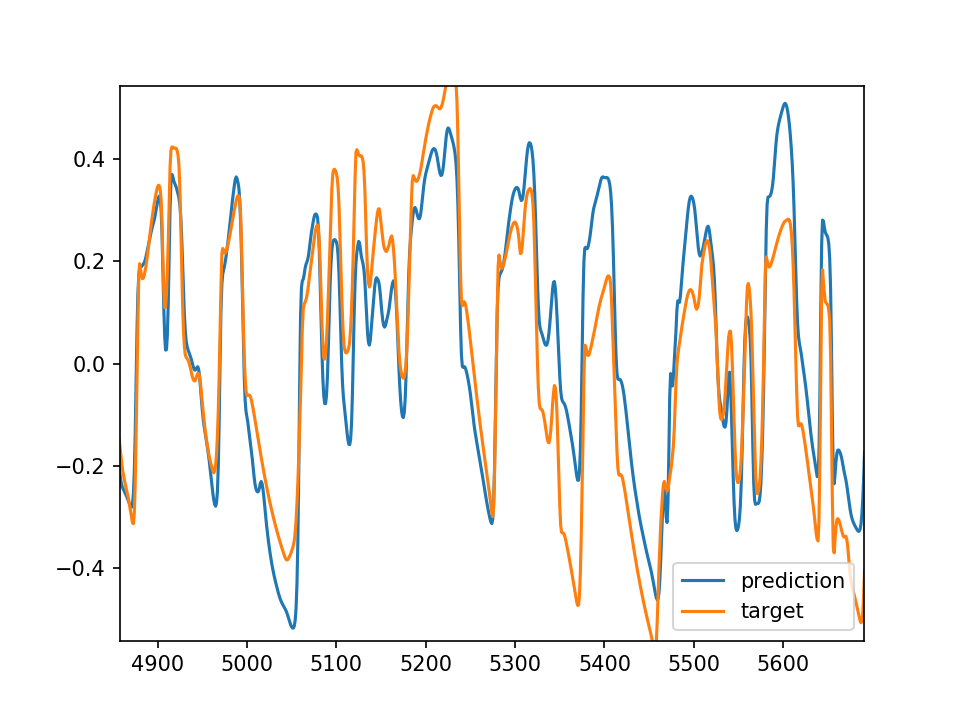

In [2]:
from show import *
%matplotlib notebook
showPickle(nameFigEstimation)